The best way to figure out what a learning rule does and a code is to compare and read through them. Therefore, here I will compare two different codes of Oja's and BCM learning rule and compare them.

We will play with the MNIST data set and see some statistical property of the dataset, especially the different PCA components, factor analysis and ICA

First, we will fetch the MNIST data and use 1/10 of the whole data sets for study.

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


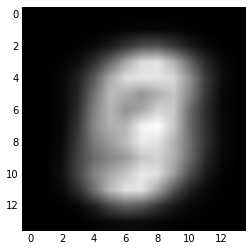

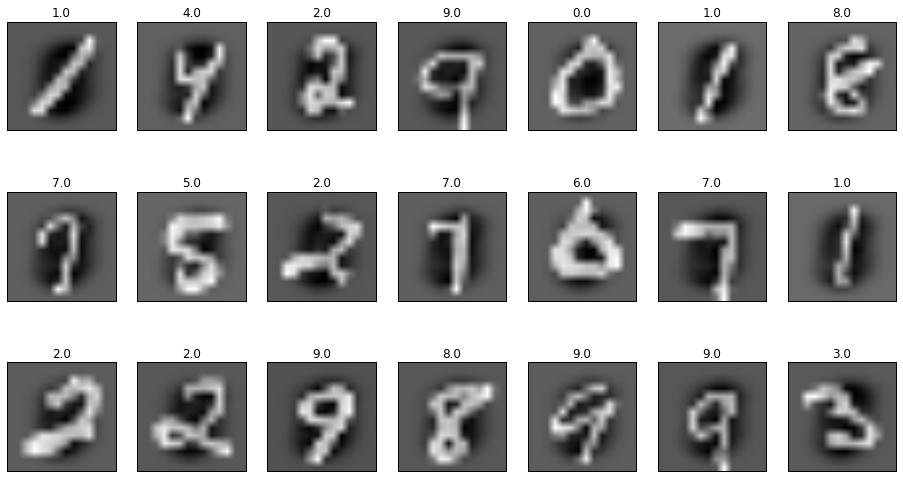

In [30]:
%reset -f
# Load necessary library modules
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import nengo as ng
# import tensorflow as ft
from sklearn.decomposition import RandomizedPCA
import tensorflow as tf
import collections
np.random.seed(seed=8723)


# Two ways to load MNIST dataset
# Using sklean
# MNIST database contains a total of 70000 examples of handwritten digits of size 28*28 pixels, labeled 0 to 9
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home = None)

# Using tensorflow
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Plot a gallery of images
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

h = 28     # height of the digit
w = 28     # width of the digit

data = np.vstack(mnist.data.data.obj).astype(float)
data = data.reshape((-1, h, w))
data = data[:,::2,::2]
h /=2
w /=2
data = data.reshape((-1, h*w))
labels = mnist.target
portion = 1.
N = int(portion*data.shape[0])
shuffle_idx = np.random.permutation(data.shape[0])[:N]
data = data[shuffle_idx]
# shuffle_idx = np.random.permutation(data.shape[0])[:N]
labels = labels[shuffle_idx]

# demean
ave_total = data.mean(axis=0)
data -= ave_total 


plt.imshow(ave_total.reshape(h,w),cmap=plt.cm.gray)
# Visualize the demeaned digits


plt_row = 3
plt_col = 7
data_view = []
titles_view = []
for i in range(plt_row*plt_col+1):
    data_view.append(data[i,:].reshape(h,w))
    titles_view.append(labels[i])

plot_gallery(data_view, titles_view, h, w, n_row=plt_row, n_col=plt_col)

# To see what BCM learning rule is really doing, we will compare it with using PCA, ICA on MNIST

# See the downloaded MNIST data
#a = np.where(labels == 3,1,0)
#collections.Counter(a)y
# Take a small portion of the dyataset

Compute the principle component of each group of digits. We need to sort the data_sm based on the label

/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


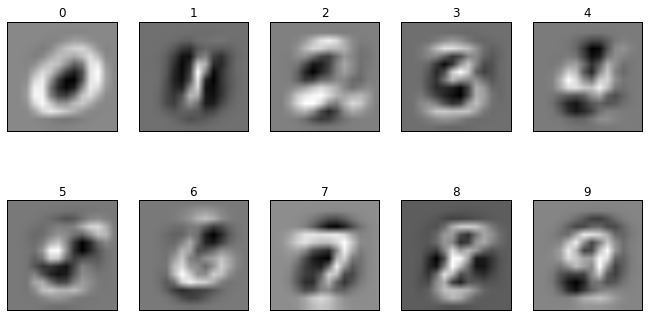

In [31]:
group_id = []
ave_digi = []
for i in range(10):
    group_id_tmp = labels == i
    group_id.append(group_id_tmp)
    ave_digi_tmp = data[group_id_tmp,:].mean(axis=0)
    ave_digi.append(ave_digi_tmp.reshape(h,w))
    
# plot the average image of each digit
plt_row = 2
plt_col = 5

titles_digi= range(10)

plot_gallery(ave_digi, titles_digi, h, w, n_row=plt_row, n_col=plt_col)

In [27]:
pca.components_.shape

(20, 196)

Extracting the top 20 eigendigits from 70000 faces
done in 0.896s


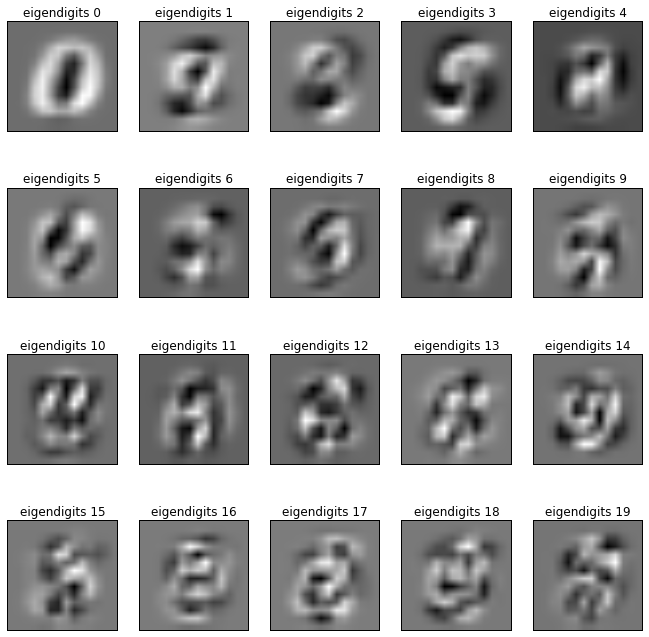

In [39]:
# PCA analysis
from time import time
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
# Split into training and testing dataset
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

# Compute the PCA (eigendigits) on the digits
n_components = 20

print("Extracting the top %d eigendigits from %d faces" % (n_components,data_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components = n_components, whiten = False).fit(data_train)
print("done in %0.3fs" % (time()-t0))

h = 14
w = 14
eigendigits = pca.components_.reshape((n_components,h,w))
eigendigits_titles = ["eigendigits %d" % i for i in range (pca.components_.shape[0])]
plot_gallery(eigendigits,eigendigits_titles,h,w,n_row= 4, n_col=5)


Extracting the top 40 icadigits from 70000 faces
done in 9.827s


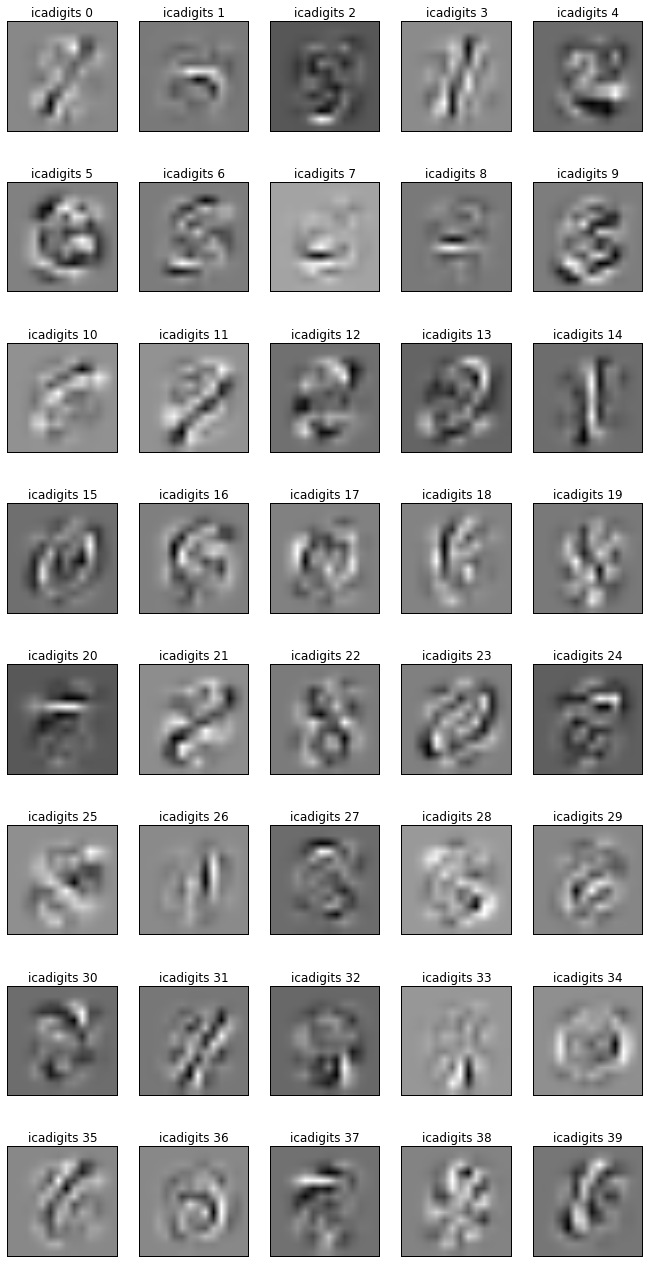

In [44]:
# Perform ICA analysis
from sklearn.decomposition import FastICA

#fica = FastICA(max_iter=500, fun='exp')
#fica.fit(data)
# plt.imshow(fica.components_, cmap=plt.cm.gray)

# Split into training and testing dataset
data_train,data_test,labels_train, labels_test = train_test_split(data,labels,test_size = 0 , random_state = 8723)

# Compute the ICA (eigendigits) on the digits
n_components = 40

print("Extracting the top %d icadigits from %d faces" % (n_components,data_train.shape[0]))
t0 = time()
ica = FastICA(n_components = n_components, whiten = True).fit(data_train)
print("done in %0.3fs" % (time()-t0))

h = 14
w = 14
icadigits = ica.components_.reshape((n_components,h,w))
icadigits_titles = ["icadigits %d" % i for i in range (ica.components_.shape[0])]
plot_gallery(icadigits,icadigits_titles,h,w,n_row= 8, n_col=5)


In [ ]:
# Test nengo library, train a neurla network with Oja's rule test nengo library

In [ ]:
# Test nengo library,train a neural network with BCM rule